In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Input, GRU, Dense,Conv1D,Conv2D, Masking, Reshape, BatchNormalization, Flatten, Conv1DTranspose, RepeatVector, TimeDistributed, Bidirectional, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
import tensorflow_probability as tfp

### Data

In [3]:
DATA = np.load('./Data/AsanTRSet.npy')

#### Env setting

In [4]:
save_path = './Results/'
if not os.path.exists(save_path):
    os.mkdir(save_path)
    
### Model checkpoint
ModelSaveSameName = save_path+'PSVAE.hdf5'
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_mse', verbose=1, save_best_only=True )

### Model Early stop
EarlyStop = EarlyStopping(monitor='val_loss', patience=500)

### Encoder

In [4]:
SigDim = DATA.shape[1]

# Hyperparameter
TB = (SigDim//100) / SigDim  # Transition band
LatDim = 10 # Latent dimension

'''
N = int(np.ceil((4 / TB)))
if not N % 2: N += 1  
'''
N = 301
nVec = np.arange(N)

def GenFilter (BH,HF, BL,LF):
        
    KaiserBH = tf.signal.kaiser_window(N, beta=BH)
    KaiserBL = tf.signal.kaiser_window(N, beta=BL)

    # A low-pass filter
    X = 2 * LF * (nVec - (N - 1) / 2)
    X = tf.maximum(X , 1e-7)
    LPF = tf.sin(np.pi*X)/(np.pi*X)
    LPF *= KaiserBL
    LPF /= tf.reduce_sum(LPF, axis=-1, keepdims=True)


    # A high-pass filter
    Y = 2 * HF * (nVec - (N - 1) / 2)
    Y = tf.maximum(Y , 1e-7)
    HPF = tf.sin(np.pi*Y)/(np.pi*Y)
    HPF *= KaiserBH
    HPF /= tf.reduce_sum(HPF, axis=-1, keepdims=True)
    HPF = -HPF

    ## HPF[(N - 1) // 2] += 1
    Mask = np.zeros(HPF.shape[1])
    Mask[(N - 1) // 2] += 1
    Mask = tf.constant(Mask, dtype=tf.float32)
    HPF = HPF + Mask
    
    return HPF[:,None], LPF[:,None] 


### Filtering level 1
InpL = Input(shape=(SigDim, 1))
Conv_11 = Conv1D(filters=5, kernel_size=20, strides=2, activation='softplus', padding='valid')(InpL)
Conv_11 = MaxPooling1D(pool_size=10,strides=3)(Conv_11)
Conv_11 = Conv1D(filters=10, kernel_size=10, strides=1, activation='softplus', padding='valid')(Conv_11)
Conv_11 = MaxPooling1D(pool_size=10,strides=2)(Conv_11)
FlatL_11 = Flatten()(Conv_11)
DenL_11 =Dense(30, activation='softplus')(FlatL_11)
DenL_11 =Dense(10, activation='softplus')(DenL_11)

## Parameters for filters
HF_11 = Dense(1, activation='sigmoid')(DenL_11)
LF_11 = Dense(1, activation='sigmoid')(DenL_11)
BH_11 = Dense(1, activation='softplus')(DenL_11)
BL_11 = Dense(1, activation='softplus')(DenL_11)

## Filter generation
HPF_11, LPF_11  = GenFilter(BH_11,HF_11, BL_11,LF_11)

## Perform signal filtering level 1
InpFrame_11 =  tf.signal.frame(InpL[:,:,0], N, 1)
HpSig_11 = tf.reduce_sum(InpFrame_11*HPF_11[:,:,::-1], axis=-1, keepdims=True)
LpSig_11 = tf.reduce_sum(InpFrame_11*LPF_11[:,:,::-1], axis=-1, keepdims=True)



### Filtering level 21 (from HpSig_11)
Conv_21 = Conv1D(filters=5, kernel_size=20, strides=2, activation='softplus', padding='valid')(HpSig_11)
Conv_21 = MaxPooling1D(pool_size=10,strides=3)(Conv_21)
Conv_21 = Conv1D(filters=10, kernel_size=20, strides=1, activation='softplus', padding='valid')(Conv_21)
Conv_21 = MaxPooling1D(pool_size=10,strides=2)(Conv_21)
FlatL_21 = Flatten()(Conv_21)
DenL_21 =Dense(30, activation='softplus')(FlatL_21)
DenL_21 =Dense(10, activation='softplus')(DenL_21)

## Parameters for filters
HF_21 = Dense(1, activation='sigmoid')(DenL_21)
LF_21 = Dense(1, activation='sigmoid')(DenL_21)
BH_21 = Dense(1, activation='softplus')(DenL_21)
BL_21 = Dense(1, activation='softplus')(DenL_21)

## Filter generation
HPF_21, LPF_21  = GenFilter(BH_21,HF_21, BL_21,LF_21)

## Perform signal filtering level 2
InpFrame_21 =  tf.signal.frame(HpSig_11[:,:,0], N, 1)
HpSig_21 = tf.reduce_sum(InpFrame_21*HPF_21[:,:,::-1], axis=-1, keepdims=True)
LpSig_21 = tf.reduce_sum(InpFrame_21*LPF_21[:,:,::-1], axis=-1, keepdims=True)



### Filtering level 22 (from LpSig_11)
Conv_22 = Conv1D(filters=5, kernel_size=20, strides=2, activation='softplus', padding='valid')(LpSig_11)
Conv_22 = MaxPooling1D(pool_size=10,strides=3)(Conv_22)
Conv_22 = Conv1D(filters=10, kernel_size=20, strides=1, activation='softplus', padding='valid')(Conv_22)
Conv_22 = MaxPooling1D(pool_size=10,strides=2)(Conv_22)
FlatL_22 = Flatten()(Conv_22)
DenL_22 =Dense(30, activation='softplus')(FlatL_22)
DenL_22 =Dense(10, activation='softplus')(DenL_22)

## Parameters for filters
HF_22 = Dense(1, activation='sigmoid')(DenL_22)
LF_22 = Dense(1, activation='sigmoid')(DenL_22)
BH_22 = Dense(1, activation='softplus')(DenL_22)
BL_22 = Dense(1, activation='softplus')(DenL_22)

## Filter generation
HPF_22, LPF_22  = GenFilter(BH_22,HF_22, BL_22,LF_22)

## Perform signal filtering level 2
InpFrame_22 =  tf.signal.frame(LpSig_11[:,:,0], N, 1)
HpSig_22 = tf.reduce_sum(InpFrame_22*HPF_22[:,:,::-1], axis=-1, keepdims=True)
LpSig_22 = tf.reduce_sum(InpFrame_22*LPF_22[:,:,::-1], axis=-1, keepdims=True)



## GRU NET
Enc_HpSig_11 = Reshape((-1, 100))(HpSig_11)
Enc_LpSig_11 = Reshape((-1, 100))(LpSig_11)
Enc_HpSig_21 = Reshape((-1, 100))(HpSig_21)
Enc_LpSig_21 = Reshape((-1, 100))(LpSig_21)
Enc_HpSig_22 = Reshape((-1, 100))(HpSig_22)
Enc_LpSig_22 = Reshape((-1, 100))(LpSig_22)

Enc_HpSig_11 = Bidirectional(GRU(10, activation='tanh', recurrent_activation='sigmoid'))(Enc_HpSig_11)
Enc_LpSig_11 = Bidirectional(GRU(10, activation='tanh', recurrent_activation='sigmoid'))(Enc_LpSig_11)
Enc_HpSig_21 = Bidirectional(GRU(10, activation='tanh', recurrent_activation='sigmoid'))(Enc_HpSig_21)
Enc_LpSig_21 = Bidirectional(GRU(10, activation='tanh', recurrent_activation='sigmoid'))(Enc_LpSig_21)
Enc_HpSig_22 = Bidirectional(GRU(10, activation='tanh', recurrent_activation='sigmoid'))(Enc_HpSig_22)
Enc_LpSig_22 = Bidirectional(GRU(10, activation='tanh', recurrent_activation='sigmoid'))(Enc_LpSig_22)


# Latent, z layers (VAE layer)
Z_Mean_1 = Dense(LatDim,  name='Z_Mean_1')(Enc_HpSig_11)
Z_Mean_2 = Dense(LatDim,  name='Z_Mean_2')(Enc_LpSig_11)
Z_Mean_3 = Dense(LatDim,  name='Z_Mean_3')(Enc_HpSig_21)
Z_Mean_4 = Dense(LatDim,  name='Z_Mean_4')(Enc_LpSig_21)
Z_Mean_5 = Dense(LatDim,  name='Z_Mean_5')(Enc_HpSig_22)
Z_Mean_6 = Dense(LatDim,  name='Z_Mean_6')(Enc_LpSig_22)

Z_Mean = tf.concat([Z_Mean_1, Z_Mean_2, Z_Mean_3, Z_Mean_4, Z_Mean_5, Z_Mean_6], axis=1)

# Latent, z layers
Z_Log_Sigma_1 = Dense(LatDim, activation='softplus', name='Z_Log_Sigma_1')(Enc_HpSig_11)
Z_Log_Sigma_2 = Dense(LatDim, activation='softplus', name='Z_Log_Sigma_2')(Enc_LpSig_11)
Z_Log_Sigma_3 = Dense(LatDim, activation='softplus', name='Z_Log_Sigma_3')(Enc_HpSig_21)
Z_Log_Sigma_4 = Dense(LatDim, activation='softplus', name='Z_Log_Sigma_4')(Enc_LpSig_21)
Z_Log_Sigma_5 = Dense(LatDim, activation='softplus', name='Z_Log_Sigma_5')(Enc_HpSig_22)
Z_Log_Sigma_6 = Dense(LatDim, activation='softplus', name='Z_Log_Sigma_6')(Enc_LpSig_22)

Z_Log_Sigma = tf.concat([Z_Log_Sigma_1, Z_Log_Sigma_2, Z_Log_Sigma_3, Z_Log_Sigma_4, Z_Log_Sigma_5, Z_Log_Sigma_6], axis=1)


# Reparameterization Trick for sampling 
Epsilon = tf.keras.backend.random_normal(shape=(tf.shape(Z_Mean)[0], Z_Mean.shape[1]), mean=0., stddev=0.1)
Z_Sampled = Z_Mean + tf.exp(0.5 * Z_Log_Sigma) * Epsilon

EncModel = Model(InpL, [Z_Mean, Z_Log_Sigma, Z_Sampled])

In [5]:
EncModel.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 491, 5)       105         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 161, 5)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 152, 10)      510         max_pooling1d[0][0]              
______________________________________________________________________________________________

### Decoder

In [6]:
InpZ = Input(shape=(LatDim*6,), name='InpZmean')
DecInp =Dense(50, activation='softplus')(InpZ)
DecInp =Dense(60, activation='softplus')(DecInp)
DecInp =Dense(80, activation='softplus')(DecInp)
#DecInp =Dense(100, activation='softplus')(DecInp)

Decoder = RepeatVector((SigDim//100) )(DecInp)
Decoder = Bidirectional(GRU(50, return_sequences=True))(Decoder)
Decoder = TimeDistributed(Dense(100))(Decoder)
#Decoder = Bidirectional(GRU(50, return_sequences=True))(Decoder)
DecOut = Dense(100, activation='sigmoid')(Decoder)
DecOut = Reshape((SigDim,),name='DecOut')(DecOut)
DecModel = Model(InpZ, DecOut)

### Vae Loss; RecMSE and KL Divergence¶

In [7]:
# apply beta and capacity
Capacity = 0.01
Beta = 0.01


### Vae Loss; KL Divergence
kl_Loss = 0.5 * tf.reduce_sum( Z_Mean**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
#kl_Loss = beta *tf.reduce_mean(kl_Loss )

kl_Loss = tf.reduce_mean(kl_Loss )
kl_Loss = Beta * tf.abs(kl_Loss - Capacity)

def RECMSE (y_true, y_pred):
    
    RecMSE = tf.losses.mse(y_true, y_pred)
    RecMSE *= InpL.shape[1]
    
    return RecMSE

In [8]:
VAEOut = DecModel(EncModel(InpL)[2])
VAEOut = Reshape((SigDim,), name='VAEOut')(VAEOut)
VAEM = Model(InpL, VAEOut, name='vae_mlp')

#VAEM.compile(optimizer='adam', loss=tf.losses.mean_squared_error, metrics={"VAEOut":'mse'})
VAEM.compile(optimizer='adam', loss=RECMSE, metrics={"VAEOut":'mse'})
VAEM.add_loss(kl_Loss )
VAEM.add_metric(kl_Loss, 'KL_D')
VAEM.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 60), (None,  93637       input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1000)         70790       model[0][2]                      
__________________________________________________________________________________________________
VAEOut (Reshape)                (None, 1000)         0           model_1[0][0]                    
____________________________________________________________________________________________

In [9]:
VAEM.load_weights(ModelSaveSameName)
VAEM.fit(DATA, DATA, batch_size=800, epochs=100, shuffle=True, validation_split=0.2, callbacks=[ModelSave, EarlyStop])

Epoch 1/100
400/400 [==============================] - 169s 297ms/step - loss: 10.4678 - mse: 0.0098 - KL_D: 0.5290 - val_loss: 1.1934 - val_mse: 8.5293e-04 - val_KL_D: 0.3405

Epoch 00001: val_mse improved from inf to 0.00085, saving model to ./Results\PSVAE.hdf5
Epoch 2/100
400/400 [==============================] - 107s 269ms/step - loss: 1.1122 - mse: 8.1859e-04 - KL_D: 0.2542 - val_loss: 0.9528 - val_mse: 7.6450e-04 - val_KL_D: 0.1883

Epoch 00002: val_mse improved from 0.00085 to 0.00076, saving model to ./Results\PSVAE.hdf5
Epoch 3/100
400/400 [==============================] - 107s 268ms/step - loss: 0.9225 - mse: 7.5446e-04 - KL_D: 0.1515 - val_loss: 0.8605 - val_mse: 7.3614e-04 - val_KL_D: 0.1244

Epoch 00003: val_mse improved from 0.00076 to 0.00074, saving model to ./Results\PSVAE.hdf5
Epoch 4/100
400/400 [==============================] - 109s 272ms/step - loss: 0.8419 - mse: 7.2569e-04 - KL_D: 0.1096 - val_loss: 0.8140 - val_mse: 7.1524e-04 - val_KL_D: 0.0988

Epoch 00004

KeyboardInterrupt: 

In [12]:
VAEM.load_weights(ModelSaveSameName)
Pred =VAEM.predict(DATA[:], batch_size=2000, verbose=1)
VAEM.evaluate(DATA[:], DATA[:], batch_size=2000, verbose=1)
np.mean((DATA[:]- Pred)**2)

200/200 [==============================] - 24s 120ms/step - loss: 0.7499 - mse: 6.6645e-04 - KL_D: 0.0834


0.00066598086

In [13]:
LatM = Model(InpL, [HpSig_11, LpSig_11, HpSig_21, LpSig_21, HpSig_22, LpSig_22 ])
PredLatM = LatM.predict(DATA[:10])


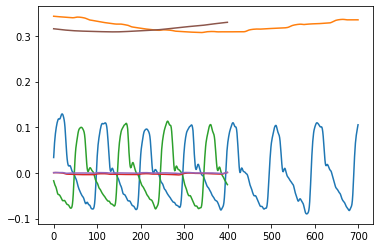

In [14]:
for i in range(6):
    plt.plot(PredLatM[i][0, :1000, 0])


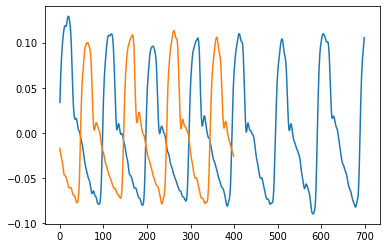

In [21]:
idx = 0
plt.plot(PredLatM[0][idx, :1000, 0])
plt.plot(PredLatM[2][idx, :1000, 0])


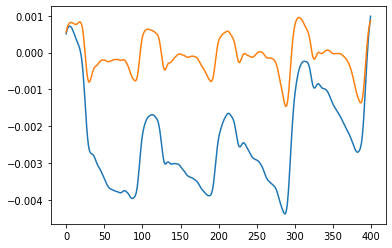

In [22]:

#plt.plot(DATA[idx])
#plt.plot(PredLatM[1][idx, :1000, 0])
plt.plot(PredLatM[3][idx, :1000, 0])
plt.plot(PredLatM[4][idx, :1000, 0])
#plt.plot(PredLatM[5][idx, :1000, 0])

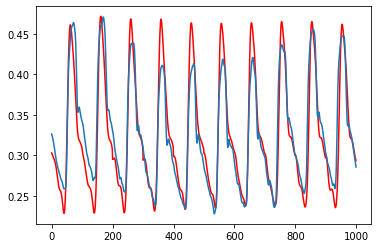

In [24]:
plt.plot(Pred[0], c='red')
plt.plot(DATA[0])

